In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve

# Set path to your dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/lrp/Genitalia'  # Update with the correct path

Found 1457 files belonging to 6 classes.
In the dataset, there are 25 files belonging to 6 classes.


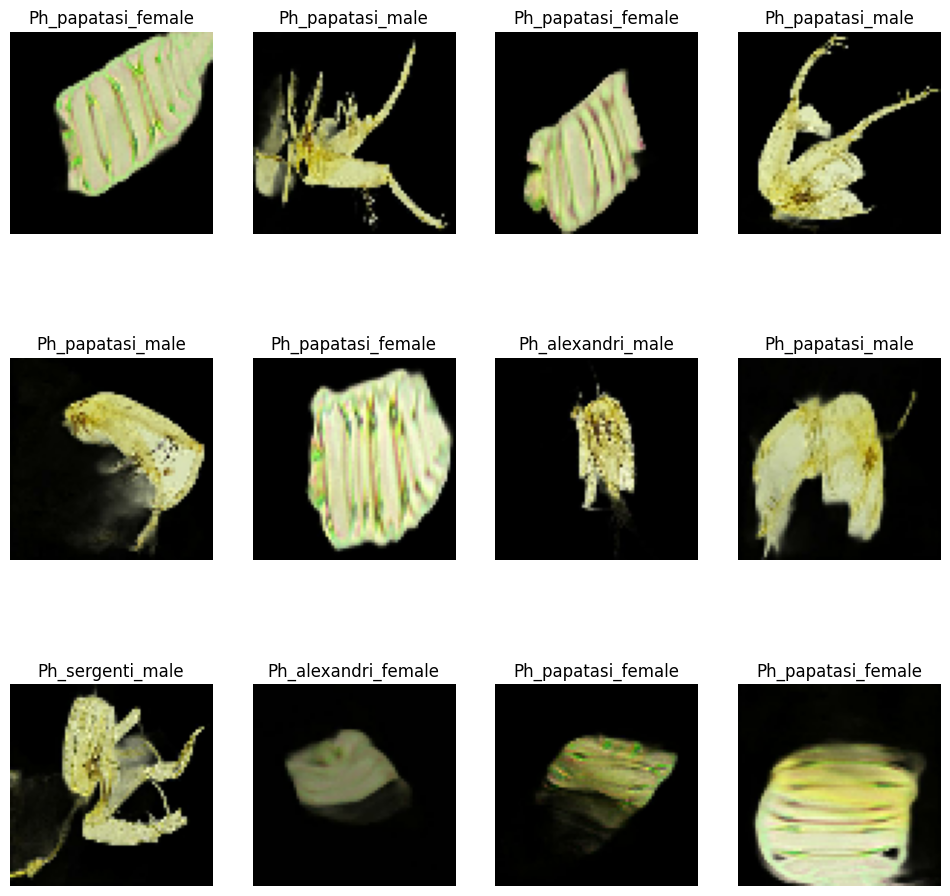

In [ ]:

# Set image parameters
IMAGE_SIZE = 70
BATCH_SIZE = 60
CHANNELS = 3
EPOCHS = 100

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(f"In the dataset, there are {len(dataset)} files belonging to {len(class_names)} classes.")

# Display sample images and labels
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Function to partition the dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Prepare the data for training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the model architecture
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)



In [ ]:
# Define the model architecture
'''model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated to remove 'experimental'
    layers.Rescaling(1.0/255),                # Updated to remove 'experimental'
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax'),  # Assuming you have 38 classes
])

model.build(input_shape=input_shape)
'''

"model = models.Sequential([\n    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated to remove 'experimental'\n    layers.Rescaling(1.0/255),                # Updated to remove 'experimental'\n    layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),\n    layers.MaxPooling2D((2, 2)),\n    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),\n    layers.MaxPooling2D((2, 2)),\n    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),\n    layers.MaxPooling2D((2, 2)),\n    layers.Flatten(),\n    layers.Dense(1024, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(1024, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(512, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(512, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(256, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(38, activation='softmax'),  # Assuming you have 38 classes\n])\n\nmodel.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, BatchNormalization, Add,
                                     Reshape, Multiply, Conv2D, Concatenate, Lambda)
from tensorflow.keras import backend as K

# CBAM Block Definition
'''def cbam_block(input_tensor, ratio=2):
    channel = K.int_shape(input_tensor)[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)
    shared_dense = Dense(channel // ratio, activation='relu')
    avg_dense = shared_dense(avg_pool)
    max_dense = shared_dense(max_pool)
    channel_attention = Add()([avg_dense, max_dense])
    channel_attention = Dense(channel, activation='sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    channel_refined = Multiply()([input_tensor, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    refined = Multiply()([channel_refined, spatial_attention])

    return refined'''

"def cbam_block(input_tensor, ratio=2):\n    channel = K.int_shape(input_tensor)[-1]\n\n    # Channel Attention\n    avg_pool = GlobalAveragePooling2D()(input_tensor)\n    max_pool = GlobalMaxPooling2D()(input_tensor)\n    shared_dense = Dense(channel // ratio, activation='relu')\n    avg_dense = shared_dense(avg_pool)\n    max_dense = shared_dense(max_pool)\n    channel_attention = Add()([avg_dense, max_dense])\n    channel_attention = Dense(channel, activation='sigmoid')(channel_attention)\n    channel_attention = Reshape((1, 1, channel))(channel_attention)\n    channel_refined = Multiply()([input_tensor, channel_attention])\n\n    # Spatial Attention\n    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)\n    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)\n    concat = Concatenate(axis=-1)([avg_pool, max_pool])\n    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)\n    refined = Multiply

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

# Channel Attention
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True)
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Spatial Attention
def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

# CBAM Block
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

# Custom CNN Model
def customCNN(input_shape, IMAGE_SIZE):
    inputs = layers.Input(shape=input_shape)
    x = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    x = layers.Rescaling(1.0/255)(x)

    # Block 1
    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (70, 70, 3)  # Example
IMAGE_SIZE = 70

model = customCNN(input_shape, IMAGE_SIZE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 70, 70, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 70, 70, 3) │          0 │ resizing[0][0]    │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 69, 69,    │        416 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d[0][0]      │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        132 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 32)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 69, 69,    │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 69, 69, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 69, 69, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 69, 69, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 69, 69, 1) │         98 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 69, 69,    │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 34, 34,    │          0 │ multiply_1[0][0]

 Total params: 5,242,240 (20.00 MB)

 Trainable params: 5,242,240 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# model = models.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255),
#     layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(6, activation='softmax'),  # Assuming you have 38 classes
# ])

# model.build(input_shape=input_shape)


#optimizer = tf.keras.optimizers.SGD(learning_rate=0.006, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.006)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define callbacks
# checkpoint_path = '/content/drive/MyDrive'  # Update with the desired model path
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
# )

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
'''early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=30,  # Number of epochs to wait before stopping
    restore_best_weights=True
)'''


#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=1)

'''reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=30,
    verbose=1,
    min_lr=0.0001
)'''

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [ ]:
import os

for subdir, _, files in os.walk("/content/drive/MyDrive/PAPER DATASET/Genitalia1"):
    for file in files:
        path = os.path.join(subdir, file)
        if os.path.getsize(path) == 0:
            print(f"Empty file: {path}")

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=200,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr]
    #callbacks=[early_stopping, reduce_lr]
    #callbacks=[early_stopping]
)

# Evaluate the model
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 688ms/step - accuracy: 0.1528 - loss: 1.7926 - val_accuracy: 0.1667 - val_loss: 1.7926 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1929 - loss: 1.7803 - val_accuracy: 0.2583 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2816 - loss: 1.5421 - val_accuracy: 0.3167 - val_loss: 1.4280 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3581 - loss: 1.3448 - val_accuracy: 0.3833 - val_loss: 1.2624 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3563 - loss: 1.2098 - val_accuracy: 0.3750 - val_loss: 1.1377 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3423 - loss: 1.1666 - val_accuracy: 0.3500 - val_loss: 1.1452 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3714 - loss: 1.1463

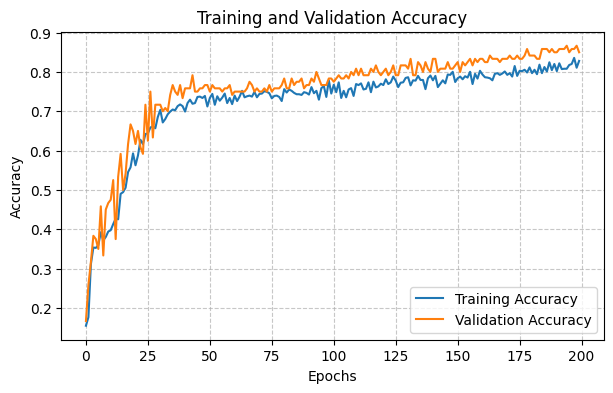

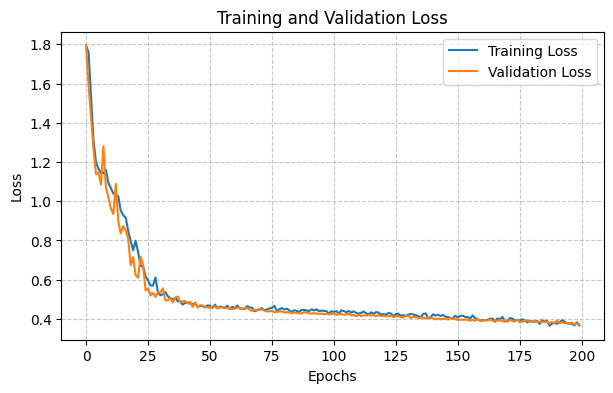

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


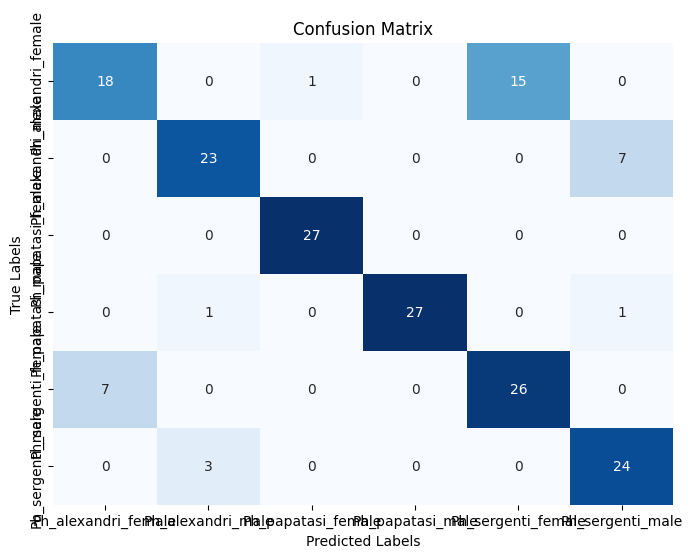

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot the training and validation accuracy
# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Make predictions on the test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Get the predicted labels

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)
plt.show()


Second Version CNN

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

# Channel Attention
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True)
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Spatial Attention
def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

# CBAM Block
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

# Custom CNN Model
def customCNN1(input_shape, IMAGE_SIZE):
    inputs = layers.Input(shape=input_shape)
    x = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    x = layers.Rescaling(1.0/255)(x)

    # Block 1
    x = layers.Conv2D(32, (2, 2), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (2, 2), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(64, (2, 2), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (70, 70, 3)  # Example
IMAGE_SIZE = 70

model = customCNN1(input_shape, IMAGE_SIZE)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 70, 70, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 70, 70, 3) │          0 │ resizing_1[0][0]  │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 69, 69,    │        416 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 69, 69,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 69, 69,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ activation_3[0][… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_6[0][0],  │
│                     │                   │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_13[0][0],   │
│                     │                   │            │ dense_13[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 1, 32)  │          0 │ dense_14[0][0],   │
│                     │                   │            │ dense_14[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1, 1, 32)  │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 69, 69,    │          0 │ activation_3[0][… │
│ (Multiply)          │ 32)               │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 69, 69, 1) │          0 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 69, 69, 1) │          0 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 69, 69, 2) │          0 │ lambda_6[0][0],   │
│ (Concatenate)       │                   │            │ lambda_7[0][0]  

 Total params: 5,242,880 (20.00 MB)

 Trainable params: 5,242,560 (20.00 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
'''early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=30,  # Number of epochs to wait before stopping
    restore_best_weights=True
)'''



reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)


# Train the model
history = model.fit(
    train_ds,
    epochs=200,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr]
    #callbacks=[early_stopping, reduce_lr]
    #callbacks=[early_stopping]
)

# Evaluate the model
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.1574 - loss: 1.8030 - val_accuracy: 0.1500 - val_loss: 1.7960 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3267 - loss: 1.5395 - val_accuracy: 0.1417 - val_loss: 1.8441 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3480 - loss: 1.2912 - val_accuracy: 0.1917 - val_loss: 1.9602 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3510 - loss: 1.1843 - val_accuracy: 0.1500 - val_loss: 2.1916 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3673 - loss: 1.1361 - val_accuracy: 0.1917 - val_loss: 2.4954 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4073 - loss: 1.0978 - val_accuracy: 0.1500 - val_loss: 2.4814 - learning_rate: 7.5000e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4707 - loss: 1.0

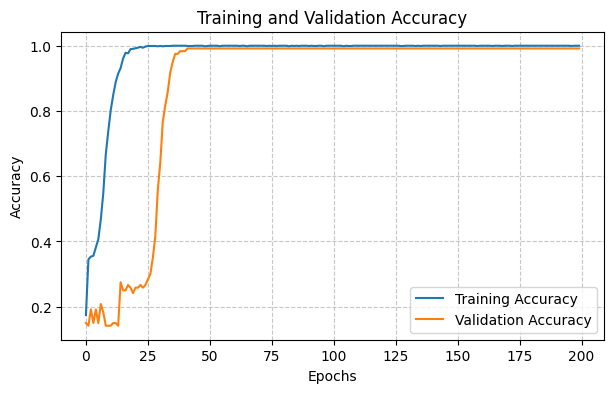

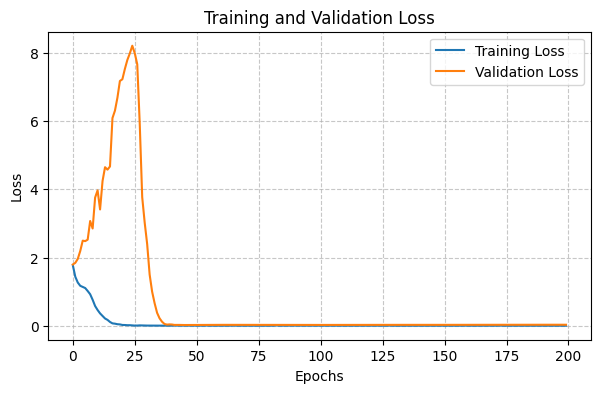

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


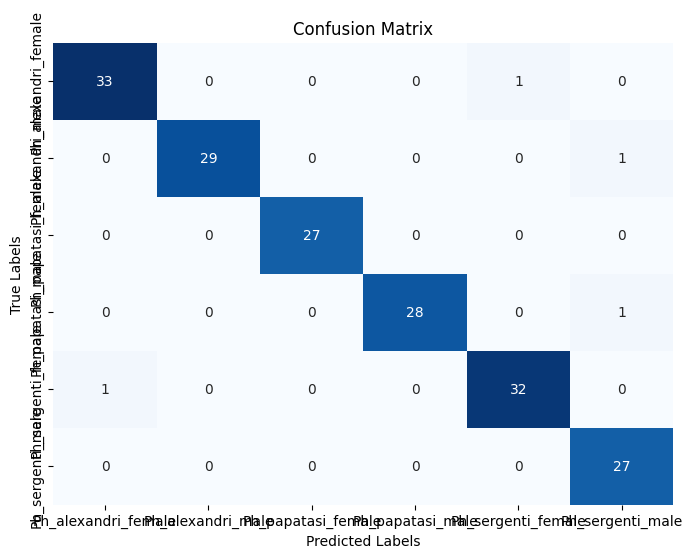

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot the training and validation accuracy
# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Make predictions on the test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Get the predicted labels

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names)
plt.show()
